Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: и . Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.



Тариф

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
Тариф

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей



Таблица (информация о пользователях):

user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана
Таблица (информация о звонках):

id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок
Таблица (информация о сообщениях):

id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение
Таблица (информация об интернет-сессиях):

id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя
Таблица (информация о тарифах):

tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### Приступим к работе и откроем все доступные для анализа файлы

Нам необходимо сравнить прибыльность, а также описать поведения пользователей по 2 тарифам.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Calls

In [2]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
# Заменяем тип данных в столбце call_date к соответствующему типу
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
# Округляем значение времени звонка в верх
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value)
# Добавим столбец с месяцем осуществлением звонка
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


In [4]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
# Заменим тип данных в столбце session_date к соответствующему типу
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
# Округлим объем переданных данных за время интернет сессии в верх
def ceil_value(value):
    return math.ceil(value)
internet['mb_used'] = internet['mb_used'].apply(ceil_value)
# Добавим столбец месяца подключения интернет сессии
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,113,2018-11-25,1000,11
1,1,1000_1,1053,2018-09-07,1000,9
2,2,1000_2,1198,2018-06-25,1000,6
3,3,1000_3,551,2018-08-22,1000,8
4,4,1000_4,303,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,319,2018-10-03,1499,10
149392,149392,1499_153,491,2018-12-14,1499,12
149393,149393,1499_154,0,2018-10-27,1499,10
149394,149394,1499_155,1247,2018-11-26,1499,11


In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
#Заменим значение столбца даты отправления сообщения на соответствующий тип
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
# Создадим столбец со значением месяца отправки сообщения
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Заменим тип данных в столбцах даты регистрации и даты прекращения к соответствующим типам
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
# Добавим столбец индентификатор тарифа по принципу 1 и 0
def tariff_id(object):
    if object == 'smart':
        return 0
    elif object == 'ultra':
        return 1
users['tariff_id'] = users['tariff'].apply(tariff_id)

users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_id
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1
...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,1
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,0
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,0
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,0


In [10]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Расчет значений и создание сводных таблиц

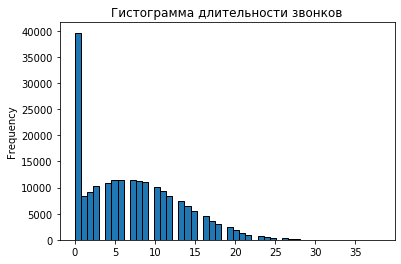

In [12]:
calls['duration'].plot(kind='hist', ec='black', bins=50, title = 'Гистограмма длительности звонков');

Согласно полученной гистаграмме мы видим большое количество звонков в около нулевом значении.Может быть, все звонки длительностью до 1 минуты, имеют длительность "0"?

In [13]:
calls.query('duration == 0.0')

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
9,1000_9,2018-08-15,0,1000,8
...,...,...,...,...,...
202590,1499_203,2018-12-03,0,1499,12
202592,1499_205,2018-10-13,0,1499,10
202593,1499_206,2018-12-26,0,1499,12
202594,1499_207,2018-10-28,0,1499,10


Не подтвердилась гипотеза - по каждому из тарифов есть нулевые звонки. Предполагаю, что это несостоявшиеся звонки. Нулевая их длительность вызвана прерыванием связи или случаями, когда у другого абонента было "занято" и поэтому происходил моментальный сброс вызова после дозвона. Т.к. они не расходуют лимиты минут и вообще не принимают участия в формировании конечной выручки, удаляем эти строки:

In [14]:
map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
calls['Тариф'] = calls['user_id'].map(map_to_fill_tariff)
calls['Тариф'].value_counts()

smart    130315
ultra     72292
Name: Тариф, dtype: int64

In [15]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

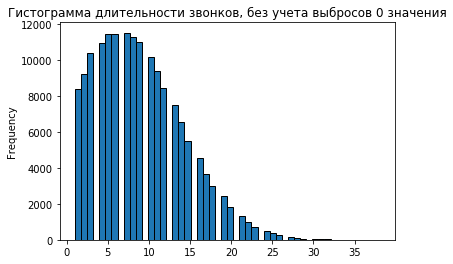

In [16]:
calls['duration'].plot(kind='hist', ec='black', bins=50, title = 'Гистограмма длительности звонков, без учета выбросов 0 значения');

После приведения данных в порядок, мы видим нормальное распределение длительности звонков

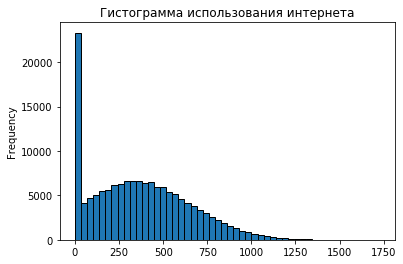

In [17]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50, title = 'Гистограмма использования интернета');

По данной гистограмме использования объема интернета мы видим выброс в около нулевом значение.

In [18]:
internet.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id,month
11,11,1000_11,0,2018-08-28,1000,8
38,38,1000_38,0,2018-11-27,1000,11
46,46,1000_46,0,2018-06-30,1000,6
67,67,1000_67,0,2018-06-16,1000,6
72,72,1000_72,0,2018-06-15,1000,6
...,...,...,...,...,...,...
149380,149380,1499_141,0,2018-12-11,1499,12
149381,149381,1499_142,0,2018-11-01,1499,11
149383,149383,1499_144,0,2018-11-27,1499,11
149386,149386,1499_147,0,2018-10-21,1499,10


Таких строк аж 20000. Это сессии, когда подключение к интернету было включено, но в дальнейшем ни одной операции произведено не было (например, случаи, когда появляется и сразу пропадает связь).
Эти строки необходимо исключить из датафрейма:

In [19]:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

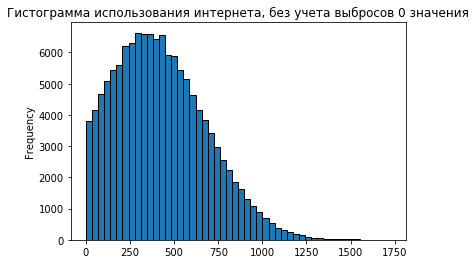

In [20]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50, title = 'Гистограмма использования интернета, без учета выбросов 0 значения');

Удалив выбросы мы видим нормальное распределение данных по использованию интернета. 

1.1.6. Посмотрим таблицу tariffs:

In [21]:
# функция определения времени года
def get_season(date):
    if date.month in [1, 2, 12]:
        return 'зима'
    elif date.month in [3, 4, 5]:
        return 'весна'
    elif date.month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

    
# столбец в формат datetime + добавление столбцов "месяц" и "время года"
def date_to_dt_month_season(dataframes):
    for df in dataframes:
        for column in df.columns:
            if 'date' in column and column != 'churn_date':
                df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
                df['месяц'] = df[column].apply(lambda x: x.month)
                df['время года'] = df[column].apply(get_season)

In [22]:
date_to_dt_month_season([users, calls, messages, internet])

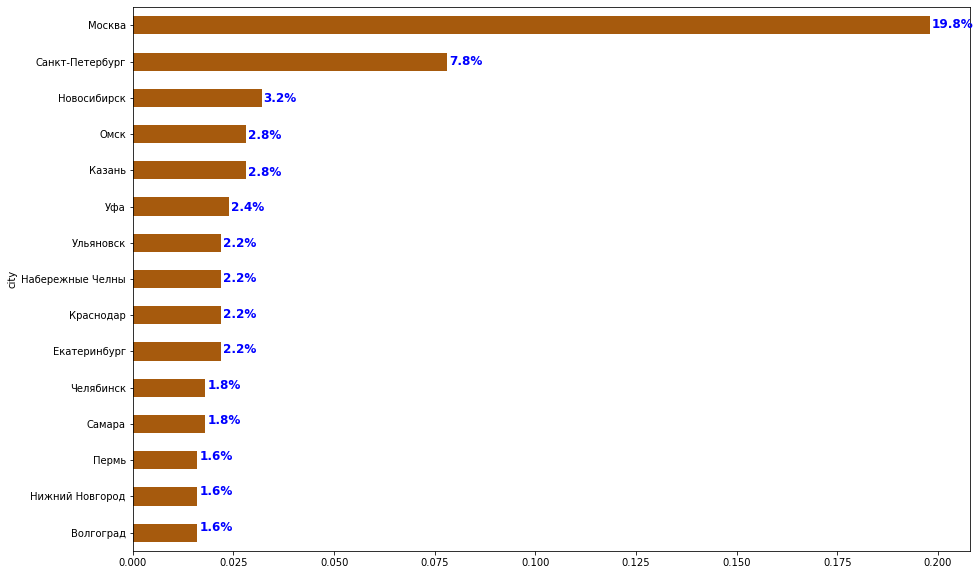

In [23]:
all_users = len(users)
df_for_barh = users.groupby('city').size()/all_users
df_for_barh_filtered = df_for_barh[df_for_barh > 0.015].sort_values()
ax = df_for_barh_filtered.plot(kind='barh', color='#A65A0D', figsize=(15,10))

labels = dict(df_for_barh_filtered)
labels

i = 0
for city in labels:
    ax.text(labels[city] + 0.0005, i + 0.05, str(round(labels[city]*100, 2)) + '%', 
            fontsize = 'large', fontweight='bold', color='blue')
    if i < 9.7:
        i += 0.98
    else:
        i += 1.02

Ожидаемо, больше всего клиентов в этом датафрейме из Москвы - почти 20%.
7,8% - из Питера.
Представителей остальных городов от ~ 3% и меньше.

1.6. Посмотрим на то, каким типом связи (звонок, отправка СМС, выход в интернет) пользуются чаще всего (по месяцам):

In [24]:
def barplot_by_month(dfs, query=None):
    list_of_dfs = dfs
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    
    list_of_colors = ['#03501A', '#6676B8', '#D39E68']

    dfs_names_for_legend = ['Кол-во звонков', 'Кол-во отпр. СМС', 'Кол-во интернет-сессий']
    legend_list = []

    for i in range(len(list_of_dfs)):
        curr_df = list_of_dfs[i]
        if query == None:
            curr_df_prepared = curr_df.groupby('месяц')['id'].count().reset_index()
        else:
            curr_df_prepared = curr_df.query(query).groupby('месяц')['id'].count().reset_index()
        plot = curr_df_prepared.plot(x='месяц', y='id', kind='bar', ec='black', color=list_of_colors[i],
                                 ax=ax, width=0.1, position=i)
        legend_list.append(dfs_names_for_legend[i])
    plt.xticks(rotation=0)
    ax.legend(legend_list)

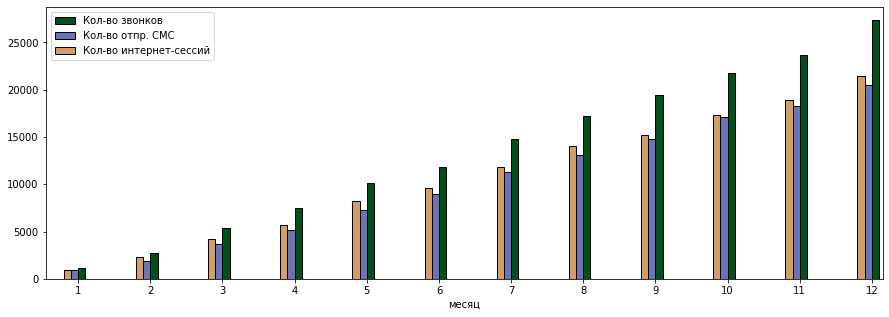

In [25]:
barplot_by_month([calls, messages, internet])

Тенденция везде одинакова: чаще всего звонят, реже всего отправляют СМС.
Выглядит странно - будто бы мы наблюдаем процесс "становления" тарифа оператора мобильной связи. В январе был его запуск, а в декабре - итог развития за год.

Посмотрим историю отдельных пользователей - например, с id "1000" и "1002":

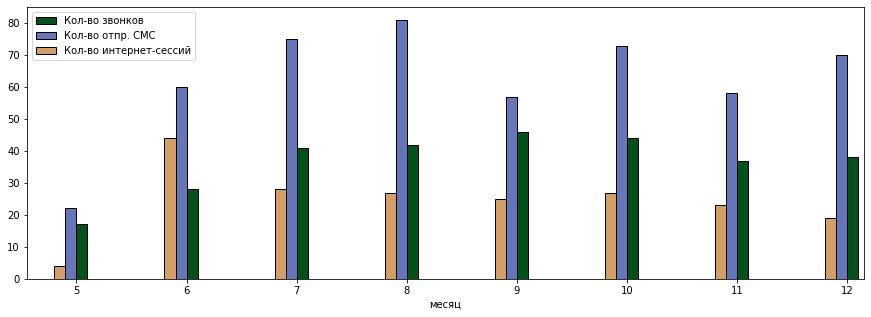

In [26]:
barplot_by_month([calls, messages, internet], query='user_id == 1000')

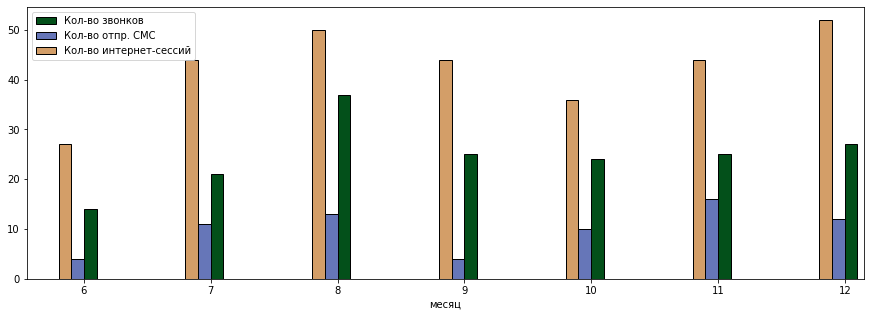

In [27]:
barplot_by_month([calls, messages, internet], query='user_id == 1002')

Всё в порядке. Данные вариативны.
Вполне возможно, что и правда были запущены 2 новых тарифа и мы собираем данные за первый год их "работы".

Посчитаем для каждого пользователя:

количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам;
помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для начала возьмем из каждого имеющегося датафрейма нужную информацию и склеим эти данные в один датафрейм df_event_numbers:

In [28]:
num_of_calls = calls.groupby(['user_id', 'время года', 'месяц'])['duration'].agg(['count', 'sum'])
num_of_messages = messages.groupby(['user_id', 'время года', 'месяц'])['id'].count()
num_of_internet = internet.groupby(['user_id', 'время года', 'месяц']).sum()['mb_used']

In [29]:
df_event_numbers = pd.concat([num_of_calls, num_of_messages, num_of_internet], axis=1)
df_event_numbers = df_event_numbers.reset_index()
df_event_numbers.head()

,user_id,время года,месяц,count,sum,id,mb_used
0,1000,весна,5,17.0,159.0,22.0,2256.0
1,1000,зима,12,38.0,333.0,70.0,9827.0
2,1000,лето,6,28.0,172.0,60.0,23257.0
3,1000,лето,7,41.0,340.0,75.0,14016.0
4,1000,лето,8,42.0,408.0,81.0,14070.0


In [30]:
#Добавим столбцы с тарифом, городом
map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
df_event_numbers['Тариф'] = df_event_numbers['user_id'].map(map_to_fill_tariff)

map_to_fill_city = dict(pd.Series(users['city'].values, index=users['user_id']))
df_event_numbers['Город'] = df_event_numbers['user_id'].map(map_to_fill_city)

In [31]:
df_event_numbers.columns = ['User_id', 'Время года', 'Месяц', 'Кол-во звонков, шт.', 'Звонки, мин.', 
                            'СМС, шт.', 'Интернет, Мб', 'Тариф', 'Город']

In [32]:
df_event_numbers.sort_values(by=['User_id', 'Месяц']).head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар
9,1001,осень,11,45.0,430.0,NaN,18452.0,smart,Москва
8,1001,зима,12,47.0,414.0,NaN,14053.0,smart,Москва


In [33]:
df_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3168 non-null float64
Звонки, мин.           3168 non-null float64
СМС, шт.               2717 non-null float64
Интернет, Мб           3201 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 226.1+ KB


In [34]:
df_event_numbers[df_event_numbers['Интернет, Мб'].isnull()]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город
592,1094,весна,5,12.0,107.0,3.0,NaN,ultra,Новосибирск
1722,1273,весна,5,19.0,220.0,21.0,NaN,ultra,Курган
1723,1273,зима,12,38.0,260.0,39.0,NaN,ultra,Курган
1724,1273,лето,6,28.0,230.0,38.0,NaN,ultra,Курган
1725,1273,лето,7,30.0,253.0,37.0,NaN,ultra,Курган
1726,1273,лето,8,39.0,253.0,41.0,NaN,ultra,Курган
1727,1273,осень,9,28.0,223.0,32.0,NaN,ultra,Курган
1728,1273,осень,10,35.0,315.0,35.0,NaN,ultra,Курган
1729,1273,осень,11,31.0,272.0,29.0,NaN,ultra,Курган
2307,1365,осень,10,5.0,43.0,1.0,NaN,smart,Ростов-на-Дону


Заполнение пропусков:

Пропуски есть по каждому из столбцов. Вероятно, некоторые из пользователей за рассматриваемый период времени или ни разу не звонили, или ни разу не отправляли СМС, или ни разу не выходили в интернет. Посмотрим, нет ли у нас пользователей, которые ни разу не звонили, не отправляли смс и не заходили в интернет:

In [35]:
df_event_numbers[(df_event_numbers['Интернет, Мб'].isnull()) & (df_event_numbers['СМС, шт.'].isnull()) &
                 (df_event_numbers['Звонки, мин.'].isnull())]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город


In [36]:
df_event_numbers = df_event_numbers.fillna(0)

In [37]:
df_event_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
User_id                3214 non-null int64
Время года             3214 non-null object
Месяц                  3214 non-null int64
Кол-во звонков, шт.    3214 non-null float64
Звонки, мин.           3214 non-null float64
СМС, шт.               3214 non-null float64
Интернет, Мб           3214 non-null float64
Тариф                  3214 non-null object
Город                  3214 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 226.1+ KB


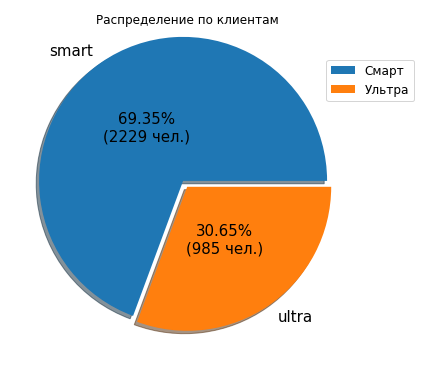

In [38]:
all_users = df_event_numbers['User_id'].count()


def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')['User_id'].count().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Распределение по клиентам', pctdistance=0.45,
                                                                     figsize=(20,5), autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), prop={'size':12})
    ax.set_ylabel('')

Посмотрим на частоту использования (проговоренные минуты, отправленные СМС и используемый интернет-трафик) по каждому из тарифов:

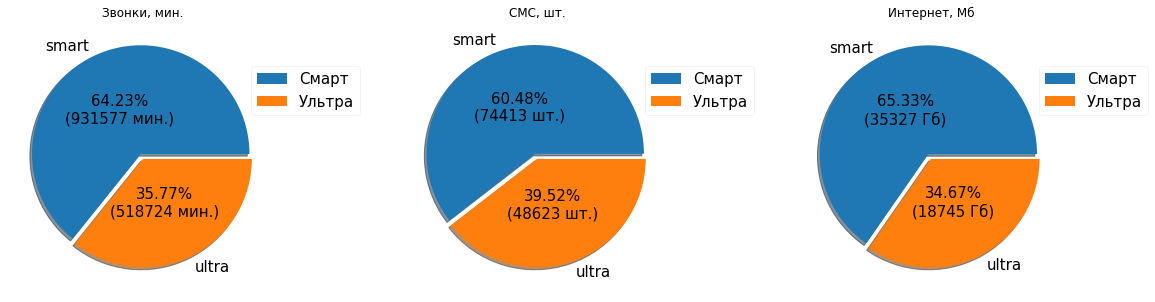

In [39]:
columns_to_plot = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Мб']

calls_sum = df_event_numbers['Звонки, мин.'].sum()
sms_sum = df_event_numbers['СМС, шт.'].sum()
internet_sum = df_event_numbers['Интернет, Мб'].sum()

def func_pct(pct):
    if pct > 65 or pct < 35:
        sum_of_data = internet_sum
        value = float(pct/100.*sum_of_data/1024)
        metric = 'Гб'
    elif pct > 64 or pct < 36:
        sum_of_data = calls_sum
        value = float(pct/100.*sum_of_data)
        metric = 'мин.'
    else:
        sum_of_data = sms_sum
        value = float(pct/100.*sum_of_data)
        metric = 'шт.'
    return "{:.2f}%\n({:.0f} {})".format(pct, value, metric)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')[columns_to_plot].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                       use_index=False, shadow=True, explode=explode,
                                                                       title = columns_to_plot, pctdistance=0.45,
                                                                       autopct=lambda pct: func_pct(pct), figsize=(20,5))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], framealpha=0.2, bbox_to_anchor=(0.87,0.87), prop={'size':15})
    ax.set_ylabel('')

Добавление информации о помесячной выручке с каждого пользователя:

Разобьем на 3 группы столбцов:

"Аб. плата";
"Минуты сверх", "СМС сверх", "Мб сверх", "Плата сверх лимита";
"Сумма за месяц".

In [40]:
#Для создания столбца "Аб. плата" создадим словарь и на его базе добавим новые данные:
month_price = {'smart': 550, 'ultra': 1950}
df_event_numbers['Аб. плата, руб.'] = df_event_numbers['Тариф'].map(month_price)

 Для создания столбцов "Минуты сверх", "СМС сверх", "Мб сверх", "Плата сверх лимита" напишем функцию, которая будет считать превышения в зависимости от тарифа:

In [41]:
df_event_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950


In [42]:
def calls_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Звонки, мин.'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['Звонки, мин.'] - 3000
        return np.where(result > 0, result, 0)
    
    
def sms_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['СМС, шт.'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['СМС, шт.'] - 1000
        return np.where(result > 0, result, 0)
    

def internet_over_plan(row):
    if row['Тариф'] == 'smart':
        result = row['Интернет, Мб'] - 15 * 1024
        return np.where(result > 0, result, 0)
    else:
        result = row['Интернет, Мб'] - 30 * 1024
        return np.where(result > 0, result, 0)
    
    
def month_revenue(row):
    sum_per_month = 0
    if row['Тариф'] == 'smart':
        sum_per_month += np.ceil(row['Минуты сверх']) * 3
        sum_per_month += row['СМС сверх'] * 3
        sum_per_month += np.ceil(row['Мб сверх']/1024) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['Минуты сверх']) * 1
        sum_per_month += row['СМС сверх'] * 1
        sum_per_month += np.ceil(row['Мб сверх']/1024) * 150
        return sum_per_month

In [43]:
#Создадим новые столбцы
df_event_numbers['Минуты сверх'] = df_event_numbers.apply(calls_over_plan, axis=1)
df_event_numbers['СМС сверх'] = df_event_numbers.apply(sms_over_plan, axis=1)
df_event_numbers['Мб сверх'] = df_event_numbers.apply(internet_over_plan, axis=1)

df_event_numbers['Плата сверх лимита, руб.'] = df_event_numbers.apply(month_revenue, axis=1)

for column in ['Минуты сверх', 'Мб сверх']:
    df_event_numbers[column] = df_event_numbers[column].astype('float')

for column in ['СМС сверх', 'Плата сверх лимита, руб.']:
    df_event_numbers[column] = df_event_numbers[column].astype('int')

In [44]:
df_event_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,1950,0.0,0,0.0,0
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,1950,0.0,0,0.0,0
8,1001,зима,12,47.0,414.0,0.0,14053.0,smart,Москва,550,0.0,0,0.0,0
9,1001,осень,11,45.0,430.0,0.0,18452.0,smart,Москва,550,0.0,0,3092.0,800


Для создания столбца "Сумма за месяц" построчно просуммируем данные по 2 только что созданным столбцам: "Аб. плата" и "Плата сверх лимита"

In [45]:
df_event_numbers['Сумма за месяц, руб.'] = df_event_numbers['Аб. плата, руб.'] + df_event_numbers['Плата сверх лимита, руб.']

In [46]:
df_event_numbers.head(10)

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб."
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
5,1000,осень,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
6,1000,осень,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
7,1000,осень,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950
8,1001,зима,12,47.0,414.0,0.0,14053.0,smart,Москва,550,0.0,0,0.0,0,550
9,1001,осень,11,45.0,430.0,0.0,18452.0,smart,Москва,550,0.0,0,3092.0,800,1350


Посмотрим, есть ли вообще клиенты, которые превышали лимиты:

In [47]:
df_event_numbers[df_event_numbers['Сумма за месяц, руб.'] > 1950]

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб."
68,1009,лето,7,20.0,183.0,14.0,24752.0,smart,Пермь,550,0.0,0,9392.0,2000,2550
69,1009,лето,8,27.0,249.0,9.0,23738.0,smart,Пермь,550,0.0,0,8378.0,1800,2350
81,1011,зима,12,44.0,361.0,6.0,22900.0,smart,Самара,550,0.0,0,7540.0,1600,2150
84,1011,лето,8,58.0,515.0,15.0,21526.0,smart,Самара,550,15.0,0,6166.0,1445,1995
87,1011,осень,11,52.0,501.0,12.0,25332.0,smart,Самара,550,1.0,0,9972.0,2003,2553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199,1496,лето,8,62.0,527.0,41.0,23560.0,smart,Вологда,550,27.0,0,8200.0,1881,2431
3200,1496,осень,9,58.0,486.0,29.0,26970.0,smart,Вологда,550,0.0,0,11610.0,2400,2950
3201,1496,осень,10,56.0,450.0,35.0,28215.0,smart,Вологда,550,0.0,0,12855.0,2600,3150
3202,1496,осень,11,66.0,662.0,46.0,25092.0,smart,Вологда,550,162.0,0,9732.0,2486,3036


Такие есть. Посмотрим, какая часть клиентов "вылезает" за рамки ежемесячных лимитов по каждому из тарифов.

2.5.4. Анализ данных по переплатам (заказам доп. пакетов услуг).

Для удобства создадим колонку 'Не хватило тарифного плана' с признаком: "0" - клиент не превышал месячные лимиты тарифа, "1" - превышал.

In [48]:
df_event_numbers['Не хватило тарифного плана'] = np.where(df_event_numbers['Плата сверх лимита, руб.'] > 0, 1, 0)

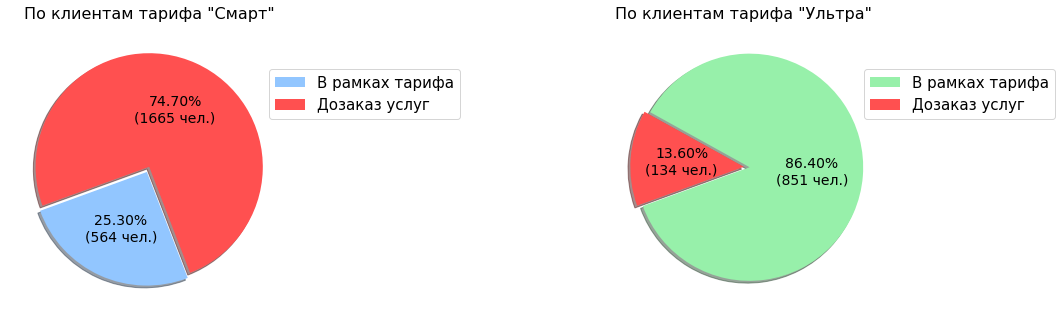

In [49]:
filter_list = ['smart', 'ultra']
titles_list = ['По клиентам тарифа "Смарт"', 'По клиентам тарифа "Ультра"']
rows = 1
cols = 2
filter_list_counter = 0

sum_smart = df_event_numbers[df_event_numbers['Тариф'] == 'smart'].count()['User_id']
sum_ultra = df_event_numbers[df_event_numbers['Тариф'] == 'ultra'].count()['User_id']

annot_labels = ['В рамках тарифа', 'Дозаказ услуг']

def func_pct(pct):
    if pct < 75 and pct > 25:
        value = float(pct/100.*sum_smart)
    else:
        value = float(pct/100.*sum_ultra)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

fig, axes = plt.subplots(rows, cols, figsize=(20,10))

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

for r in range(rows):
    for c in range(cols):
        if filter_list[filter_list_counter] == 'smart':
            colors = ['#92c6ff', '#ff5050']
        else:
            colors = ['#97F0AA', '#ff5050']
        curr_filtered_df = df_event_numbers[df_event_numbers['Тариф'] == filter_list[filter_list_counter]].groupby('Не хватило тарифного плана')['User_id']
        ax = curr_filtered_df.count().plot(kind='pie', fontsize=14, use_index=False, shadow=True, explode=explode,
                                           title=titles_list[filter_list_counter], pctdistance=0.55, figsize=(20,5),
                                           autopct=lambda pct: func_pct(pct), startangle=200, ax=axes[c], colors=colors,
                                           labels=None)

        filter_list_counter += 1

plt.tight_layout(pad=3)

for ax in axes:
    ax.legend(['В рамках тарифа', 'Дозаказ услуг'], bbox_to_anchor=(0.897,0.87), prop={'size':15})
    ax.set_ylabel('')
    ax.title.set_size(16)
    ax.title.set_position([0.5, 1.15])

Видим, что по тарифу примерно в 75% случаев клиенту не хватает заложенных в абонентскую плату минут, СМС или гигабайт, и он "дозаказывает" эти услуги.
И наоборот, почти всем клиентам с тарифом всегда всего хватает, кроме 13% - они тоже "дозаказывают" услуги вне поверх абонентской платы.

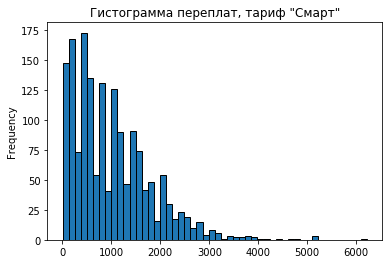

In [50]:
#Посмотрим на гистограмму "переплат" клиентов тарифа
title = 'Гистограмма переплат, тариф "Смарт"'
df_filtered = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                               (df_event_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
df_filtered.plot(kind='hist', title=title, ec='black', bins=50);

Большинство переплачивает до 1200 рублей. Это довольно много, учитывая, что размер абонентский платы - 550 рублей.
Посмотрим ближе:

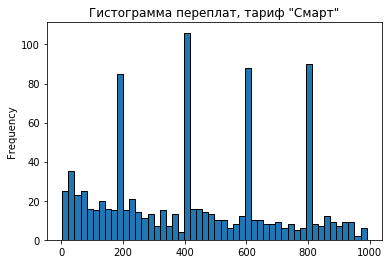

In [51]:
title = 'Гистограмма переплат, тариф "Смарт"'
df_filtered_less1000 = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') & 
                                        (df_event_numbers['Плата сверх лимита, руб.'] > 0) &
                                        (df_event_numbers['Плата сверх лимита, руб.'] < 1000)]['Плата сверх лимита, руб.']
df_filtered_less1000.plot(kind='hist', title=title, ec='black', bins=50);

Большая часть клиентов если переплачивает, то переплачивает сумму, кратную 200 рублям. То есть дозаказывают разное количество раз 1 Гб интернета за 200 рублей.

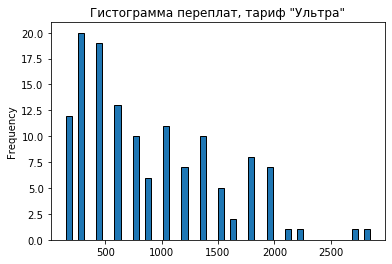

In [52]:
#Посмотрим на гистограмму "переплат" клиентов тарифа
title = 'Гистограмма переплат, тариф "Ультра"'
df_filtered = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                               (df_event_numbers['Плата сверх лимита, руб.'] > 0)]['Плата сверх лимита, руб.']
df_filtered.plot(kind='hist', title=title, ec='black', bins=50);

В основном, переплаты до 1500 рублей. Посмотрим поближе

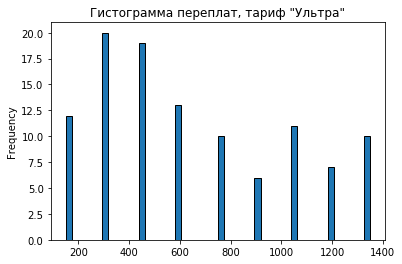

In [53]:
title = 'Гистограмма переплат, тариф "Ультра"'
df_filtered_less1000 = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') & 
                                        (df_event_numbers['Плата сверх лимита, руб.'] > 0) &
                                        (df_event_numbers['Плата сверх лимита, руб.'] < 1500)]['Плата сверх лимита, руб.']
df_filtered_less1000.plot(kind='hist', title=title, ec='black', bins=50);

Переплачивают по 150р. за дополнительный 1 Гб интернет-трафика различное количество раз.

Какие услуги чаще дозаказывают пользователи каждого из тарифов

In [54]:
(df_event_numbers.groupby('Тариф').sum()[['Минуты сверх', 'СМС сверх', 'Мб сверх']]).reset_index()

,Тариф,Минуты сверх,СМС сверх,Мб сверх
0,smart,92739.0,12928,6175667.0
1,ultra,0.0,0,743233.0


Пользователи тарифа доказывают услуги каждого типа связи. Пользователи тарифа - только интернет.

2.7. Сравнение суммарную выручку за год по каждому из тарифов:

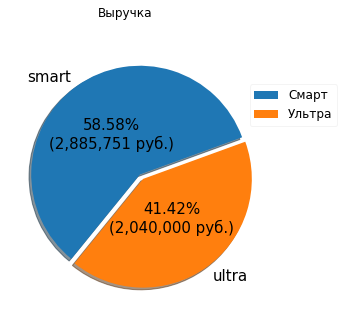

In [55]:
all_revenue = df_event_numbers['Сумма за месяц, руб.'].sum()


def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')['Сумма за месяц, руб.'].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Выручка', pctdistance=0.45,
                                                                     startangle=20, figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), framealpha=0.2, prop={'size':12})
    ax.set_ylabel('')

2.8. Сводная таблица по полученным о тарифах данным

Больше людей пользуются тарифом , больше трафика проходит через тариф , больше отправляется смс и больше совершается звонков, и, как следствие, большую часть выручки приносит тариф , даже несмотря на что, что абонентская плата по тарифу в 3 раза выше.

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

3.1. Получаем информацию о выбросах по каждому из набора данных.

Сначала построим boxplot'ы по всем рассматриваемым данным (длительность звонка, количество отправленных СМС, объем использованного интернет-трафика), чтобы зафиксировать выбросы и отфильтровать их при дальнейшем анализе. Сначала зададим нижнее и верхнее значения усов через 2 и 98 квантили и построим один boxplot, потом построим boxplot со стандартным межквартильным размахом, равным 1,5:

In [56]:
def plot_box(whis):
    column_list = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Мб']
    rows = 1
    cols = 3
    column_list_counter = 0

    fig, axes = plt.subplots(rows, cols, figsize=(40,15))

    for r in range(rows):
        for c in range(cols):
            ax = df_event_numbers.boxplot(column=column_list[column_list_counter], by='Тариф', fontsize=40, ax=axes[c],
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True, whis=whis)
            ax.set_title(column_list[column_list_counter])
            ax.title.set_size(40)
            ax.set_xlabel('')
            plt.suptitle('Boxplot с whis = {}'.format(whis), y=1, fontsize=45, fontweight='bold')
            column_list_counter += 1

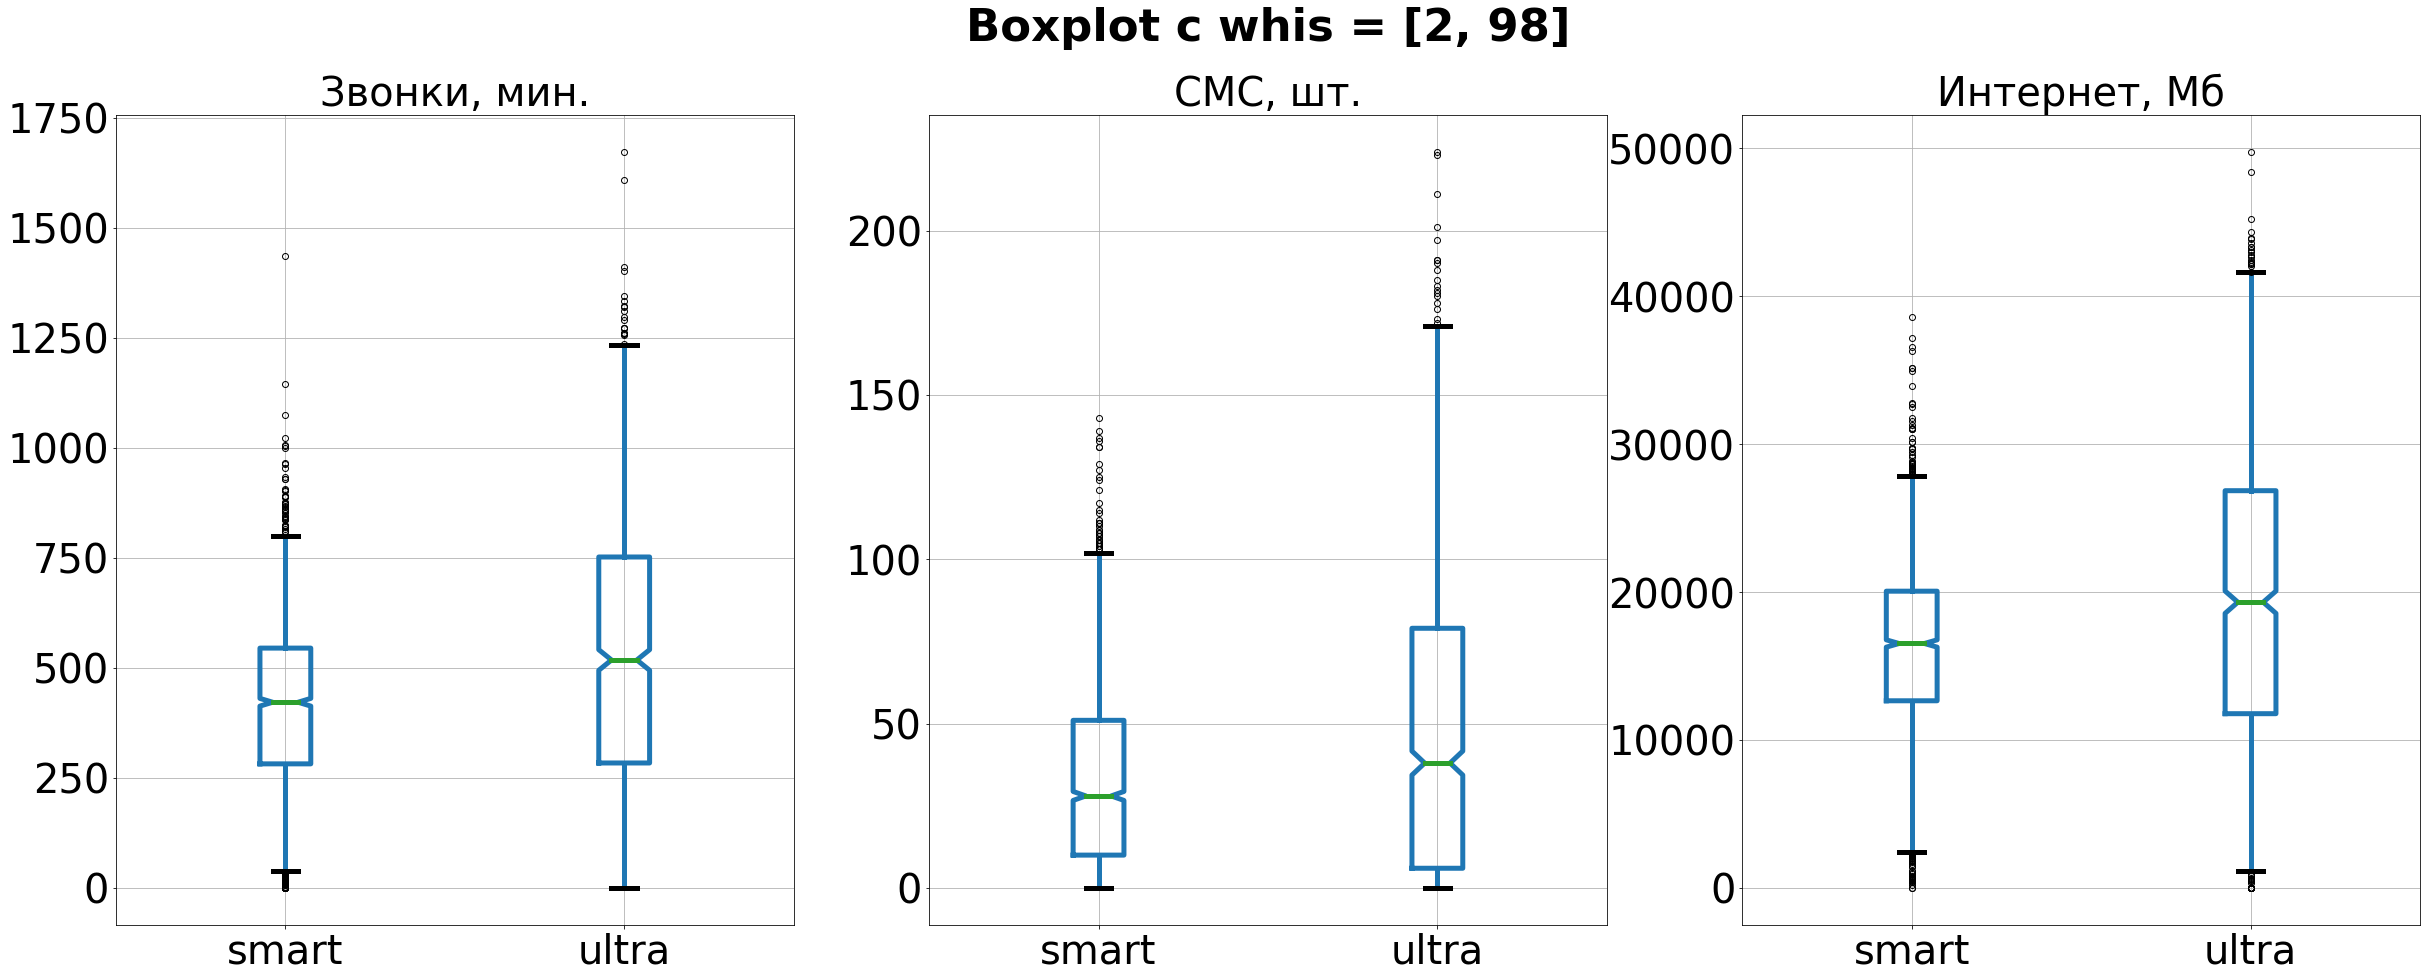

In [57]:
plot_box([2,98])

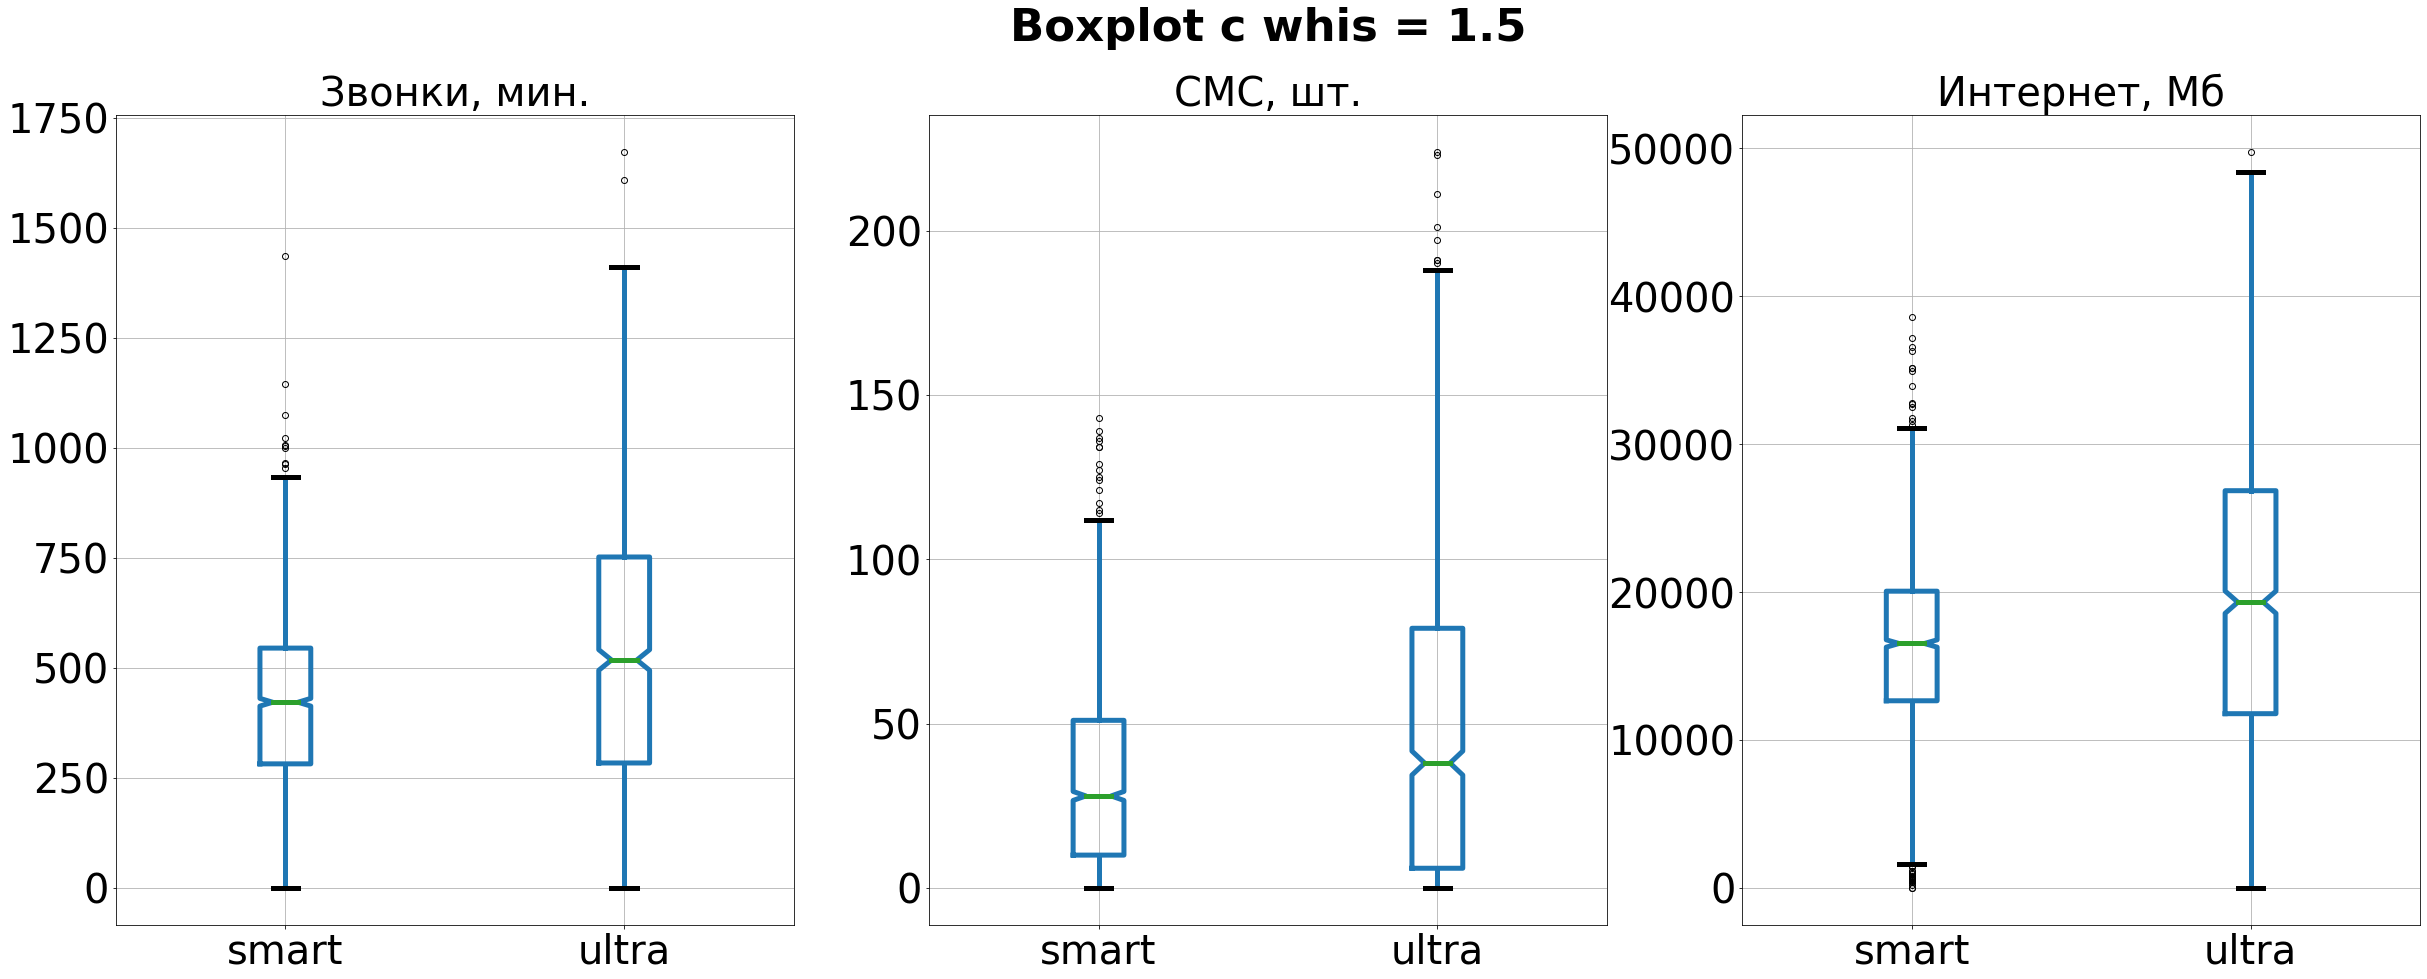

In [58]:
plot_box(1.5)

При параметре whis = 1,5 аномалий отбрасывается меньше, другими словами, мы бережней фильтруем данные, чем при [2,98].
В связи с этим, определим интервалы данных по boxplot'ам с whis = 1,5

При параметре whis = 1,5 аномалий отбрасывается меньше, другими словами, мы бережней фильтруем данные, чем при [2,98].
В связи с этим, определим интервалы данных по boxplot'ам с whis = 1,5

3.1.3. Определение интервалов данных для последующей их фильтрации

Для этого напишем функцию, которая рассчитает нам эти интервалы

In [59]:
def get_intervals(column, data_filter):
    
    if data_filter == 'Тариф':
        format_name = column
        data1, data2 = 'smart', 'ultra'
        format_end1 = 'тарифа "Смарт"'
        format_end2 = 'тарифа "Ультра"'
    elif data_filter == 'is_Moscow':
        format_name = 'is_Moscow'
        data1, data2 = 0, 1
        format_end1 = 'для регионов'
        format_end2 = 'для Москвы'
    
    q1_1 = df_event_numbers[df_event_numbers[data_filter] == data1][column].quantile(0.25)
    q3_1 = df_event_numbers[df_event_numbers[data_filter] == data1][column].quantile(0.75)
    diff_1 = q3_1 - q1_1
    
    if data_filter == 'is_Moscow':
        left_int_1 = np.where( (q1_1 - 1.5 * diff_1) > 550, q1_1 - 1.5 * diff_1, 550)
    else:
        left_int_1 = np.where( (q1_1 - 1.5 * diff_1) > 0, q1_1 - 1.5 * diff_1, 0)
    
    right_int_1 = np.where( (q3_1 + 1.5 * diff_1) > 0, q3_1 + 1.5 * diff_1, 0)
    
    q1_2 = df_event_numbers[df_event_numbers[data_filter] == data2][column].quantile(0.25)
    q3_2 = df_event_numbers[df_event_numbers[data_filter] == data2][column].quantile(0.75)
    diff_2 = q3_2 - q1_2
    
    if data_filter == 'is_Moscow':
        left_int_2 = np.where( (q1_2 - 1.5 * diff_2) > 550, q1_2 - 1.5 * diff_2, 550)
    else:
        left_int_2 = np.where( (q1_2 - 1.5 * diff_2) > 0, q1_2 - 1.5 * diff_2, 0)
        
    right_int_2 = np.where( (q3_2 + 1.5 * diff_2) > 0, q3_2 + 1.5 * diff_2, 0)
    
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, format_end1, left_int_1, right_int_1))
    print('Границы интервала для столбца "{}" {}: {} - {}'.format(column, format_end2, left_int_2, right_int_2))
    
    return (left_int_1, right_int_1), (left_int_2, right_int_2)

In [60]:
#Найдем границы интервала по длительности звонков
calls_int_smart, calls_int_ultra = get_intervals('Звонки, мин.', 'Тариф')

Границы интервала для столбца "Звонки, мин." тарифа "Смарт": 0.0 - 939.5
Границы интервала для столбца "Звонки, мин." тарифа "Ультра": 0.0 - 1454.0


In [61]:
#Найдем границы интервала по количеству отправленных СМС
sms_int_smart, sms_int_ultra = get_intervals('СМС, шт.', 'Тариф')

Границы интервала для столбца "СМС, шт." тарифа "Смарт": 0.0 - 112.5
Границы интервала для столбца "СМС, шт." тарифа "Ультра": 0.0 - 188.5


In [62]:
#Найдем границы интервала по количеству использованного трафика
internet_int_smart, internet_int_ultra = get_intervals('Интернет, Мб', 'Тариф')

Границы интервала для столбца "Интернет, Мб" тарифа "Смарт": 1543.0 - 31183.0
Границы интервала для столбца "Интернет, Мб" тарифа "Ультра": 0.0 - 49480.0


3.2. Построим гистограммы по тарифам по длительности звонков, по количеству отправленных смс, по количеству потраченного интернет-трафика. Помимо этого, выведем на расчетные данные по среднему, дисперсии и стандартному отклонению:

In [63]:
#Напишем для этого функцию:
def plot_hist_comparison(data):
    
    ax = plt.gca()
    func_dict = {'Звонки': 'Звонки, мин.', 'СМС': 'СМС, шт.', 'Интернет': 'Интернет, Мб'}
    xlims = [(calls_int_smart[0], calls_int_smart[1]), (calls_int_ultra[0], calls_int_ultra[1]),
             (sms_int_smart[0], sms_int_smart[1]), (sms_int_ultra[0], sms_int_ultra[1]),
             (internet_int_smart[0], internet_int_smart[1]), (internet_int_ultra[0], internet_int_ultra[1])]
    
    filt_column = func_dict[data]

    # оформление в зависимости от рассматриваемых данных
    if data == 'Звонки':
        title = 'Гистограмма длительности звонков, мин.'
        xlim1 = xlims[0]
        xlim2 = xlims[1]
        text_x = (58, 8)
        text_y = 118
        count_text_x = 1150
        count_text_y = 75
        alpha = 0.8
        # annot_xy = (990, 60)
        # annot_xytext = (970, 70)
    elif data == 'СМС':
        title = 'Гистограмма количества отправленных СМС, шт.'
        xlim1 = xlims[2]
        xlim2 = xlims[3]
        text_x = (5.5, 1)
        text_y = 200
        count_text_x = 148
        count_text_y = 230
        alpha = 1
        # annot_xy = (133, 220)
        # annot_xytext = (130, 260)
    else:
        title = 'Гистограмма количества использованного интернет-трафика, Мб'
        xlim1 = xlims[4]
        xlim2 = xlims[5]
        text_x = (3300, 200)
        text_y = 130
        count_text_x = 38000
        count_text_y = 82
        alpha = 0.8
        # annot_xy = (31100, 73)
        # annot_xytext = (30400, 86)
    
    # получаем отфильтрованные от выбросов датафреймы
    filtered_smart_data = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') &
                                           (df_event_numbers[filt_column] >= xlim1[0]) &
                                           (df_event_numbers[filt_column] <= xlim1[1])][filt_column]
    filtered_ultra_data = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') &
                                           (df_event_numbers[filt_column] >= xlim2[0]) &
                                           (df_event_numbers[filt_column] <= xlim2[1])][filt_column]
    # рисуем
    filtered_smart_data.plot(kind='hist', bins=40, figsize=(12,6), ec='black', ax=ax, color='#92c6ff', 
                             title=title, xlim=xlim1)
    filtered_ultra_data.plot(kind='hist', bins=70, figsize=(12,6), ec='black', ax=ax, color='#97F0AA', 
                             title=title, xlim=xlim2, alpha=alpha)
    
    # расчетные данные
    mean_smart = filtered_smart_data.mean()
    mean_ultra = filtered_ultra_data.mean()
    dispersion_smart = filtered_smart_data.var()
    dispersion_ultra = filtered_ultra_data.var()
    std_smart = filtered_smart_data.std()
    std_ultra = filtered_ultra_data.std()
    
    if data == 'СМС':
        smart_data = 'Среднее - {:.2f}\nДисперсия - {:.2f}\nstd - {:.2f}'.format(mean_smart, dispersion_smart, std_smart)
        ultra_data = 'Среднее - {:.2f}\nДисперсия - {:.2f}\nstd - {:.2f}'.format(mean_ultra, dispersion_ultra, std_ultra)
    else:
        smart_data = 'Среднее - {:.0f}\nДисперсия - {:.0f}\nstd - {:.0f}'.format(mean_smart, dispersion_smart, std_smart)
        ultra_data = 'Среднее - {:.0f}\nДисперсия - {:.0f}\nstd - {:.0f}'.format(mean_ultra, dispersion_ultra, std_ultra)
    
    legend_second = plt.legend([smart_data, ultra_data], prop={'size':10.5}, 
                                framealpha=0, bbox_to_anchor=(1.0,0.32), loc=4)
    
    
    plt.gca().add_artist(legend_second)
    
    # рисуем медианы
    plt.axvline(x=filtered_smart_data.median(),linewidth=3, color='#16B4DC', linestyle='--')
    ax.text(filtered_smart_data.median()-text_x[0], text_y, '{0:.0f}'.format(filtered_smart_data.median()), 
            fontweight='bold', fontsize='large')
    plt.axvline(x=filtered_ultra_data.median(),linewidth=3, color='#35B815', linestyle='--')
    ax.text(filtered_ultra_data.median()+text_x[1], text_y, '{0:.0f}'.format(filtered_ultra_data.median()), 
            fontweight='bold', fontsize='large')
    
    plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12})
    ax.text(count_text_x, count_text_y, 'Расчетные данные', fontweight='bold', fontsize='large')
    
    # ax.annotate('Расчетные данные', xy=annot_xy, xytext=annot_xytext, arrowprops=dict(facecolor='black', shrink=0.05),
                # horizontalalignment='right', verticalalignment='top')

3.2.1. Гистограмма длительности звонков:

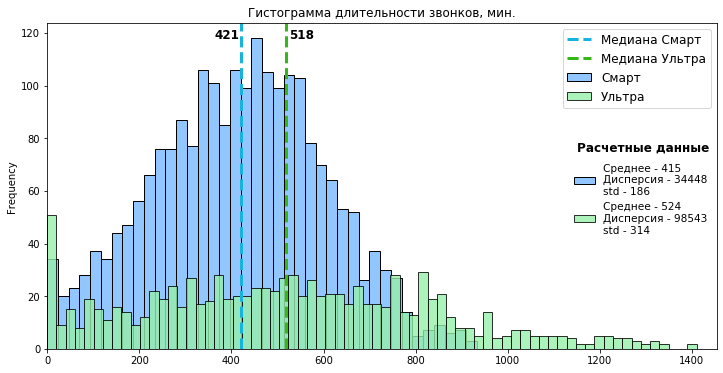

In [64]:
plot_hist_comparison('Звонки')

В основном, на тарифе люди разговаривают в месяц в течение 250-550 минут. Причем медиана равна 421 минуте, когда лимит общения по тарифу за абонентскую плату - 500 минут, т.е. пользователи регулярно выбирают почти полный лимит голосовой связи.
С тарифом немного иная ситуация - большая часть пользователей вообще не разговаривает голосом. Из тех, кто разговаривает, в среднем наговаривают 518 минут.
По итогу, медиана тарифа больше, чем медиана .

3.2.2. Гистограмма количества отправленных СМС:

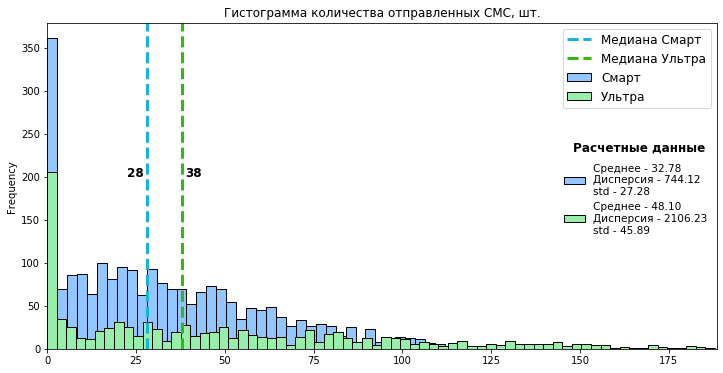

In [65]:
plot_hist_comparison('СМС')

По обоим тарифам ситуация схожая - большая часть пользователей не отправляет СМС сообщения.</br> Однако, из тех, кто отправляет, большую активность проявляют пользователи тарифа - в среднем они отправляют до 30 СМС в месяц. Пользователи тарифа отправляют до 50 СМС.

3.2.3. Гистограмма использованного интернет-трафику

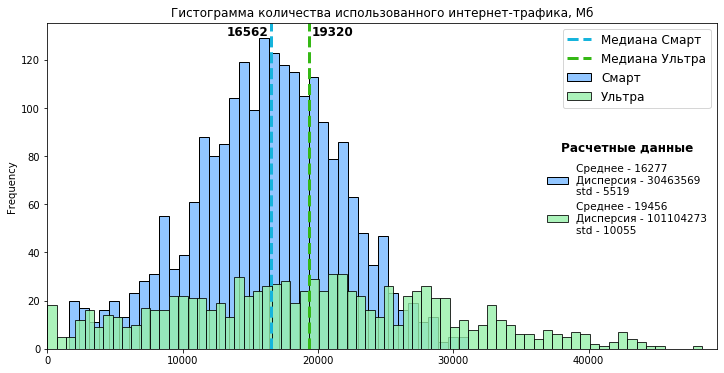

In [66]:
plot_hist_comparison('Интернет')

Клиенты с тарифом в среднем в месяц используют от 14 до 20 Гб трафика. Причем медиана равна 16,5 Гб, что "вылезает" за пределы, установленные абонентской платой - в 15 Гб. Фактически, клиенты тарифа регулярно заказывают доп. пакеты с интернетом, когда основной пакет заканчивается.
Клиенты с тарифом активней пользуются интернетом - медиана равна 19 Гб, но учитывая лимит в 30 Гб, у них есть ещё большой запас по количеству оставшегося для использования трафика.

Шаг 4. Проверка гипотез

средняя выручка пользователей тарифов

H0 (нулевая гипотеза) - предположение о том, что между данными у нас нет связи. В данном случае, что средняя выручка пользователей тарифа не отличается от средней выручки пользователей тарифа .
H1 (альтернативная гипотеза) - средняя выручка пользователей тарифа отличается от средней выручки пользователей тарифа

4.1.1. Формирование выборок без аномалий:

Text(0.5, 0.93, 'Boxplot по выручке с whis = 1,5')

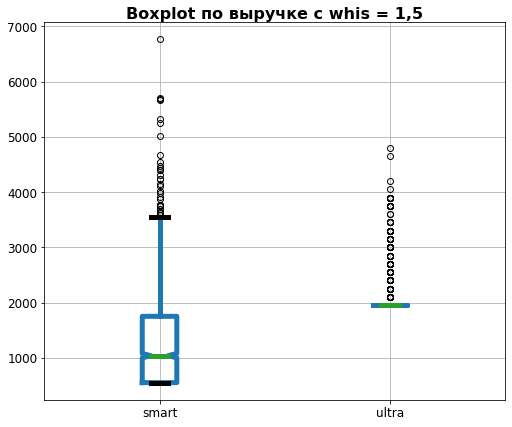

In [67]:
#Посмотрим на выбросы
ax = df_event_numbers.boxplot(column='Сумма за месяц, руб.', by='Тариф', fontsize=12,
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True, figsize=(8,7))
ax.set_title('')
ax.title.set_size(40)
ax.set_xlabel('')
plt.suptitle('Boxplot по выручке с whis = 1,5', y=0.93, fontsize=16, fontweight='bold')

Посчитаем границы интервалов:

In [68]:
revenue_int_smart, revenue_int_ultra = get_intervals('Сумма за месяц, руб.', 'Тариф')

Границы интервала для столбца "Сумма за месяц, руб." тарифа "Смарт": 0.0 - 3550.0
Границы интервала для столбца "Сумма за месяц, руб." тарифа "Ультра": 1950.0 - 1950.0


Выберем нужные нам данные - среднюю месячную выручку по тарифам и "Ультра":

In [69]:
smart_mean_revenue = df_event_numbers[(df_event_numbers['Тариф'] == 'smart') &
                                      (df_event_numbers['Сумма за месяц, руб.'] >= revenue_int_smart[0]) &
                                      (df_event_numbers['Сумма за месяц, руб.'] <= revenue_int_smart[1])]['Сумма за месяц, руб.']

ultra_mean_revenue = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra') &
                                      (df_event_numbers['Сумма за месяц, руб.'] >= revenue_int_ultra[0]) &
                                      (df_event_numbers['Сумма за месяц, руб.'] <= revenue_int_ultra[1])]['Сумма за месяц, руб.']

4.1.2. Расчет p-value:

Т.к. выборки у нас независимые, воспользуемся функцией ttest_ind из модуля scipy.stats

In [70]:
stat, p = ttest_ind(smart_mean_revenue, ultra_mean_revenue)
print('t = {}\np-value = {:.10e}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = -27.932596508963062
p-value = 4.6244593529e-153

Пороговое значение alpha = 0.05


4.1.3. Итог.

Нулевую гипотезу отвергаем.
Верно утверждение, что средняя выручка пользователей тарифов Смарт отличается от средней выручки пользователей тарифа Ультра.

In [71]:
print('Средняя выручка по пользователям тарифа "Смарт" - {:.2f}'.format(smart_mean_revenue.mean()))
print('Средняя выручка по пользователям тарифа "Ультра" - {}'.format(ultra_mean_revenue.mean()))

Средняя выручка по пользователям тарифа "Смарт" - 1249.74
Средняя выручка по пользователям тарифа "Ультра" - 1950.0


Ожидаемо, что пользователи тарифа "Ультра" в среднем приносят больше денег, т.к. их абонентская плата в 3,5 раза выше, чем абонентская плата пользующихся тарифом (1950р. против 550р.). Клиенты с тарифом , конечно, довольно часто (в 75% случаев) "вылезают" за пределы своего тарифа и заказывают доп. услуги, но всё равно не догоняют по тратам на пользователя клиентов с тарифом .

средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

4.2.1. Формирование выборок без аномалий:
Выберем нужные нам данные - среднюю месячную выручку по Москве и по остальным регионам:

Проставим признак по каждой строке - Москва или регион:

In [72]:
df_event_numbers['is_Moscow'] = np.where(df_event_numbers['Город'] == 'Москва', 1, 0)

In [73]:
df_event_numbers.head()

,User_id,Время года,Месяц,"Кол-во звонков, шт.","Звонки, мин.","СМС, шт.","Интернет, Мб",Тариф,Город,"Аб. плата, руб.",Минуты сверх,СМС сверх,Мб сверх,"Плата сверх лимита, руб.","Сумма за месяц, руб.",Не хватило тарифного плана,is_Moscow
0,1000,весна,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0,0
1,1000,зима,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0,0
2,1000,лето,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0,0
3,1000,лето,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0,0
4,1000,лето,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0,0


Построим boxplot'ы для вычисления выбросов:

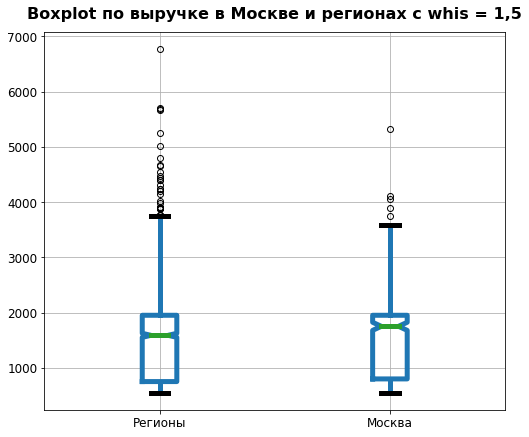

In [74]:
ax = df_event_numbers.boxplot(column='Сумма за месяц, руб.', by='is_Moscow', fontsize=12,
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True, figsize=(8,7))



labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Регионы'
labels[1] = 'Москва'

ax.set_xticklabels(labels)

plt.suptitle('Boxplot по выручке в Москве и регионах с whis = 1,5', y=0.95, fontsize=16, fontweight='bold')

ax.set_xlabel('')
ax.set_title('')
ax.title.set_size(40)

Рассчитаем границы интервалов

In [75]:
revenue_int_smart, revenue_int_ultra = get_intervals('Сумма за месяц, руб.', 'is_Moscow')

Границы интервала для столбца "Сумма за месяц, руб." для регионов: 550.0 - 3750.0
Границы интервала для столбца "Сумма за месяц, руб." для Москвы: 550.0 - 3678.0


Выберем нужные данные - выручку по Москве и по регионам - и произведем расчеты

In [76]:
moscow_revenue = df_event_numbers[(df_event_numbers['Город'] == 'Москва') &
                                  (df_event_numbers['Сумма за месяц, руб.'] >= revenue_int_smart[0]) &
                                  (df_event_numbers['Сумма за месяц, руб.'] <= revenue_int_smart[1])]['Сумма за месяц, руб.']

regions_revenue = df_event_numbers[(df_event_numbers['Город'] != 'Москва') &
                                  (df_event_numbers['Сумма за месяц, руб.'] >= revenue_int_ultra[0]) &
                                  (df_event_numbers['Сумма за месяц, руб.'] <= revenue_int_ultra[1])]['Сумма за месяц, руб.']

4.2.2. Расчет p-value:

H0 (нулевая гипотеза) - предположение о том, что между данными у нас нет связи. В данном случае, что средняя выручка пользователей тарифов из Москвы не отличается от средней выручки пользователей тарифов из других регионов. H1 (альтернативная гипотеза) - средняя выручка пользователей тарифов из Москвы отличается от средней выручки пользователей тарифов из других регионов.

Т.к. выборки у нас независимые, воспользуемся функцией ttest_ind из модуля scipy.stats

In [77]:
stat, p = ttest_ind(moscow_revenue, regions_revenue)
print('t = {}\np-value = {:.2}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 1.49291699198228
p-value = 0.14

Пороговое значение alpha = 0.05


4.2.3. Итог.

Нулевую гипотезу отвергнуть не получается.
Таким образом, верно утверждение, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Ради интереса посмотрим на выручку по Москве и по регионам

In [78]:
print('Средняя выручка по пользователю в месяц в Москве: {:.2f}'.format(moscow_revenue.mean()))
print('Средняя выручка по пользователю в месяц в регионах: {:.2f}'.format(regions_revenue.mean()))

Средняя выручка по пользователю в месяц в Москве: 1532.38
Средняя выручка по пользователю в месяц в регионах: 1483.28


В Москве в среднем платят на 50р. больше, чем в регионах. И правда, было бы странно, если бы эта разница оказалась статистически значимой.

Шаг 5. Общий вывод

5.1. Cоберем общие данные по тарифам по части использования включенных в абонентскую плату лимитов и по части дозаказываемых (пакетов) услуг:

In [79]:
smart_mean_internet = (df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Интернет, Мб']/(1024 * 15)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Смарт" - {:.2%} = {:,.0f} Гб'.
      format(smart_mean_internet, smart_mean_internet * 1024 * 15))
smart_mean_calls = (df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Звонки, мин.']/(500)).mean()
print('Средний процент использования пакета минут по тарифу "Смарт" - {:.2%} = {:.2f} мин'.
      format(smart_mean_calls, smart_mean_calls * 500))
smart_mean_sms = (df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['СМС, шт.']/(50)).mean()
print('Средний процент использования пакета СМС по тарифу "Смарт" - {:.2%} = {:.0f} шт.'.
      format(smart_mean_sms, smart_mean_sms * 50))
print('---------------------------------------------------------------------------------')
ultra_mean_internet = (df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Интернет, Мб']/(1024 * 30)).mean()
print('Средний процент использования пакета интернет-трафика по тарифу "Ультра" - {:.2%} = {:,.0f} Гб'.
      format(ultra_mean_internet, ultra_mean_internet * 1024 * 30))
ultra_mean_calls = (df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Звонки, мин.']/(3000)).mean()
print('Средний процент использования пакета минут по тарифу "Ультра" - {:.2%} = {:.2f} мин'.
      format(ultra_mean_calls, ultra_mean_calls * 3000))
ultra_mean_sms = (df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['СМС, шт.']/(1000)).mean()
print('Средний процент использования пакета СМС по тарифу "Ультра" - {:.2%} = {:.0f} шт.'.
      format(ultra_mean_sms, ultra_mean_sms * 1000))

Средний процент использования пакета интернет-трафика по тарифу "Смарт" - 105.66% = 16,229 Гб
Средний процент использования пакета минут по тарифу "Смарт" - 83.59% = 417.93 мин
Средний процент использования пакета СМС по тарифу "Смарт" - 66.77% = 33 шт.
---------------------------------------------------------------------------------
Средний процент использования пакета интернет-трафика по тарифу "Ультра" - 63.43% = 19,487 Гб
Средний процент использования пакета минут по тарифу "Ультра" - 17.55% = 526.62 мин
Средний процент использования пакета СМС по тарифу "Ультра" - 4.94% = 49 шт.


5.2. Информация по самим переплатам:

In [80]:
smart_over_mean_internet = df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Мб сверх'].mean()
smart_over_mean_internet_rub = np.round(smart_over_mean_internet, -3)/1000 * 200
print('Среднее превышение пакета интернет по тарифу "Смарт" - {:.0f} Мб на сумму - {:.0f} руб.'.
      format(smart_over_mean_internet, smart_over_mean_internet_rub))

smart_over_mean_calls = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['Минуты сверх'].mean())
smart_over_mean_calls_rub = smart_over_mean_calls * 3
print('Среднее превышение пакета минут по тарифу "Смарт" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(smart_over_mean_calls, smart_over_mean_calls_rub))

smart_over_mean_sms = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'smart')]['СМС сверх'].mean())
smart_over_mean_sms_rub = smart_over_mean_sms * 3
print('Среднее превышение пакета СМС по тарифу "Смарт" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(smart_over_mean_sms, smart_over_mean_sms_rub))

print('----------------------------------------------------------------')

ultra_over_mean_internet = df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Мб сверх'].mean()
ultra_over_mean_internet_rub = np.round(ultra_over_mean_internet, -3)/1000 * 150
print('Среднее превышение пакета интернет по тарифу "Ультра" - {:.0f} Мб на сумму - {:.0f} руб.'.
      format(ultra_over_mean_internet, ultra_over_mean_internet_rub))

ultra_over_mean_calls = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['Минуты сверх'].mean())
ultra_over_mean_calls_rub = ultra_over_mean_calls * 3
print('Среднее превышение пакета минут по тарифу "Ультра" - {:.0f} мин на сумму - {:.0f} руб.'.
      format(ultra_over_mean_calls, ultra_over_mean_calls_rub))

ultra_over_mean_sms = np.ceil(df_event_numbers[(df_event_numbers['Тариф'] == 'ultra')]['СМС сверх'].mean())
ultra_over_mean_sms_rub = ultra_over_mean_sms * 3
print('Среднее превышение пакета СМС по тарифу "Ультра" - {:.0f} шт. на сумму - {:.0f} руб.'.
      format(ultra_over_mean_sms, ultra_over_mean_sms_rub))

Среднее превышение пакета интернет по тарифу "Смарт" - 2771 Мб на сумму - 600 руб.
Среднее превышение пакета минут по тарифу "Смарт" - 42 мин на сумму - 126 руб.
Среднее превышение пакета СМС по тарифу "Смарт" - 6 шт. на сумму - 18 руб.
----------------------------------------------------------------
Среднее превышение пакета интернет по тарифу "Ультра" - 755 Мб на сумму - 150 руб.
Среднее превышение пакета минут по тарифу "Ультра" - 0 мин на сумму - 0 руб.
Среднее превышение пакета СМС по тарифу "Ультра" - 0 шт. на сумму - 0 руб.


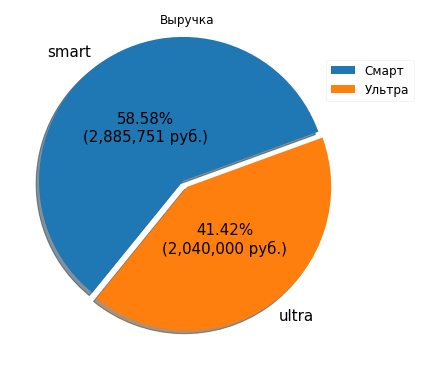

In [81]:
all_revenue = df_event_numbers['Сумма за месяц, руб.'].sum()


def func_pct(pct):
    value = float(pct/100.*all_revenue)
    return "{:.2f}%\n({:,.0f} руб.)".format(pct, value)

explode = (0.05, 0)  # сектор 'ultra' немного выдвинем

axes = df_event_numbers.groupby('Тариф')['Сумма за месяц, руб.'].sum().plot(kind='pie', subplots=True, fontsize=15,
                                                                     use_index=False, shadow=True, explode=explode,
                                                                     title = 'Выручка', pctdistance=0.45,
                                                                     startangle=20, figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))

for ax in axes:
    ax.legend(['Смарт', 'Ультра'], bbox_to_anchor=(0.87,0.87), framealpha=0.2, prop={'size':12})
    ax.set_ylabel('')
    
ax.title.set_size(40)
plt.tight_layout(pad=0)

Тариф Смарт приносит около 60% всей выручки, но при этом на него приходится 2200 пользователей. Тариф Ультра дает остальные 40%, но эту выручку генерируют всего 1000 пользователей.
Среднему пользователю тарифа Смарт не хватает 2 Гб интернета к заложенными в абонентскую плату 15 Гб и ему приходится дозаказывать эти 2 Гб и доплачивать за них 400 рублей.
Если рассматривать только тех пользователей , кто вылезает за лимиты по интернет-трафику, то средний размер доп. заказа интернет-трафика равен 3 Гб, за которые они платят 600 рублей.

Таким образом, в тарифной сетке есть дешевый тариф Смарт за 550 рублей, где пользователю не хватает интернета и количество использованных минут разговора на грани лимита (418 мин из 500), и есть тариф Ультра, стоимостью 1950 рублей, которым пользуется уже другой класс граждан, где лимитов по всем типам связи предостаточно (иногда дозаказывают в среднем 1 Гб интернета).

Итог таков, что "Мегалайну" надо подумать и выработать промежуточное решение, которое позволяло бы клиенту более комфортно, без доп. заказов, пользоваться услугами связи (особенно мобильным интернетом), при этом по цене являлось бы промежуточным вариантом между текущими и . Учитывая то, что средний пользователь тарифа Смарт дозаказывает 2 Гб на 400 рублей, т.е. платит в итоге 550 + 400 = 950 рублей за месяц, это значит, что эти деньги клиент готов тратить в месяц в качестве абонентской платы. Например, можно рассмотреть вариант создания тарифа, в дополнение к текущим, под названием Оптимальный".

Если же исходить из выгоды, для компании "Мегалайн", определенно выгоден тариф Смарт, так как имея не высокую абонентскую плату покрывает намного большую целевую аудитория представляющих потенциальных клиентов, а основная выручка будет формироваться за счет продажи дополнительных пакетов услуг.